In [3]:
from Src.FedProx_models import *
from Src.utils import *

In [4]:
## uncomment for colab
## upload datasetGenerator.py for preprocessing dataset

# from google.colab import drive
# drive.mount('/content/drive')
# ! unzip -q "/content/drive/MyDrive/Colab Notebooks/BVP.zip"
# ! python /content/datasetGenerator.py

Mounted at /content/drive
client 1 data extraction:

Loaded dataset of 3525 samples, each sized (38, 20, 20)

client 2 data extraction:

Loaded dataset of 3248 samples, each sized (38, 20, 20)

client 3 data extraction:

Loaded dataset of 2500 samples, each sized (38, 20, 20)

client 4 data extraction:

Loaded dataset of 375 samples, each sized (38, 20, 20)

client 5 data extraction:

Loaded dataset of 500 samples, each sized (38, 20, 20)

client 6 data extraction:

Loaded dataset of 624 samples, each sized (38, 20, 20)

client 7 data extraction:

Loaded dataset of 374 samples, each sized (38, 20, 20)

client 8 data extraction:

Loaded dataset of 374 samples, each sized (38, 20, 20)

client 9 data extraction:

Loaded dataset of 375 samples, each sized (38, 20, 20)

client 10 data extraction:

Loaded dataset of 375 samples, each sized (38, 20, 20)

client 11 data extraction:

Loaded dataset of 375 samples, each sized (38, 20, 20)

client 12 data extraction:

Loaded dataset of 375 sample

In [5]:
fraction_for_test = 0.15
num_class = 4
ALL_MOTION = [i for i in range(1, num_class+1)]
N_MOTION = len(ALL_MOTION) # Number of output classes
T_MAX = 38 # Number of timestamps
n_gru_hidden_units = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

destination_folder = './results'
try:
    os.makedirs(destination_folder)
except:
    pass

# Model

In [6]:
class CNNModule(nn.Module):
    def __init__(self):
        super(CNNModule, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=2, padding='same'),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(8 * 10 * 10, 64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, 32),
            nn.ReLU()
        )

    def forward(self, x):
        return self.cnn(x)

class ConvGRUModel(nn.Module):
    def __init__(self, hidden_size, num_classes, num_timestamps):
        super(ConvGRUModel, self).__init__()

        # CNN module for each input timestamp
        self.cnn_modules = nn.ModuleList([
            CNNModule() for _ in range(num_timestamps)
        ])

        # GRU layers
        self.gru = nn.GRU(32, hidden_size, num_layers=num_timestamps, batch_first=True, dropout=0.25)

        # Fully connected layer at the output of last GRU
        self.fc_out = nn.Linear(hidden_size, num_classes)

        # Relu activation for fully connected
        self.relu = nn.ReLU()
        # Softmax activation for classification
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Apply CNN module sequentially for each timestamp
        x = x.unsqueeze(2)
        x = np.swapaxes(x, 0, 1)
        x = [module(xi) for module, xi in zip(self.cnn_modules, x)]
        x = torch.stack(x, dim=1)  # Stack along the time dimension

        # GRU layer
        x, _ = self.gru(x)

        # Apply ReLU activation after the GRU layer
        x = self.relu(x)

        # Fully connected layer at the output of last GRU
        x = self.fc_out(x[:, -1, :])

        # Softmax for classification
        x = self.softmax(x)

        return x

## Load dataset

In [7]:
# Load datasets
num_clients = 5
batch_size = 128
client_datasets = {}
client_loaders = {}

for i in range(1, num_clients + 1):
    # Load client data
    client_data = torch.load(f'./data/data{i}.pt')
    data = torch.from_numpy(client_data['data']).float()
    label = torch.from_numpy(client_data['label']).long()

    # Split data into training and testing sets
    data_train, data_test, label_train, label_test = train_test_split(
        data, label, test_size=fraction_for_test, random_state=42
    )

    train_dataset = TensorDataset(data_train, label_train)
    test_dataset = TensorDataset(data_test, label_test)
    client_datasets[f'client{i}'] = {'train': train_dataset, 'test':test_dataset}

    # Set up data loaders for each client's
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    client_loaders[f'client{i}'] = {'train': train_loader, 'test':test_loader}

## FedProx

In [21]:
fed_prox = FedProxAlgorithm(model=ConvGRUModel,
                            n_gru_hidden_units=n_gru_hidden_units,
                            num_class=N_MOTION,
                            timestamp=T_MAX,
                            train_loader=client_loaders,
                            mu=0.1
                            )

fed_prox_round_accuracy, fed_prox_result = fed_prox.run(num_rounds=10,
                                                        num_epochs=4)

# Save to a file using pickle
with open('./results/fed_prox_result.pkl', 'wb') as file:
    pickle.dump(fed_prox_result, file)

with open('./results/fed_prox_round_accuracy.pkl', 'wb') as file:
    pickle.dump(fed_prox_round_accuracy, file)

---------- Round 1/10 ----------

Training on Client 1
        Epoch: 1, Train Loss: 1.5369, Train Accuracy: 25.63%,  Val Loss: 1.3841, Val Accuracy: 25.71%
        Epoch: 2, Train Loss: 1.6996, Train Accuracy: 26.34%,  Val Loss: 1.3834, Val Accuracy: 25.71%
        Epoch: 3, Train Loss: 1.8319, Train Accuracy: 25.37%,  Val Loss: 1.3831, Val Accuracy: 30.81%
        Epoch: 4, Train Loss: 1.9573, Train Accuracy: 25.97%,  Val Loss: 1.3844, Val Accuracy: 25.71%

Training on Client 2
        Epoch: 1, Train Loss: 1.6107, Train Accuracy: 33.66%,  Val Loss: 1.3660, Val Accuracy: 33.81%
        Epoch: 2, Train Loss: 1.7863, Train Accuracy: 34.78%,  Val Loss: 1.3638, Val Accuracy: 33.81%
        Epoch: 3, Train Loss: 1.8215, Train Accuracy: 34.78%,  Val Loss: 1.3644, Val Accuracy: 33.81%
        Epoch: 4, Train Loss: 1.8336, Train Accuracy: 34.78%,  Val Loss: 1.3641, Val Accuracy: 33.81%

Training on Client 3
        Epoch: 1, Train Loss: 1.5596, Train Accuracy: 33.74%,  Val Loss: 1.3516, Val 

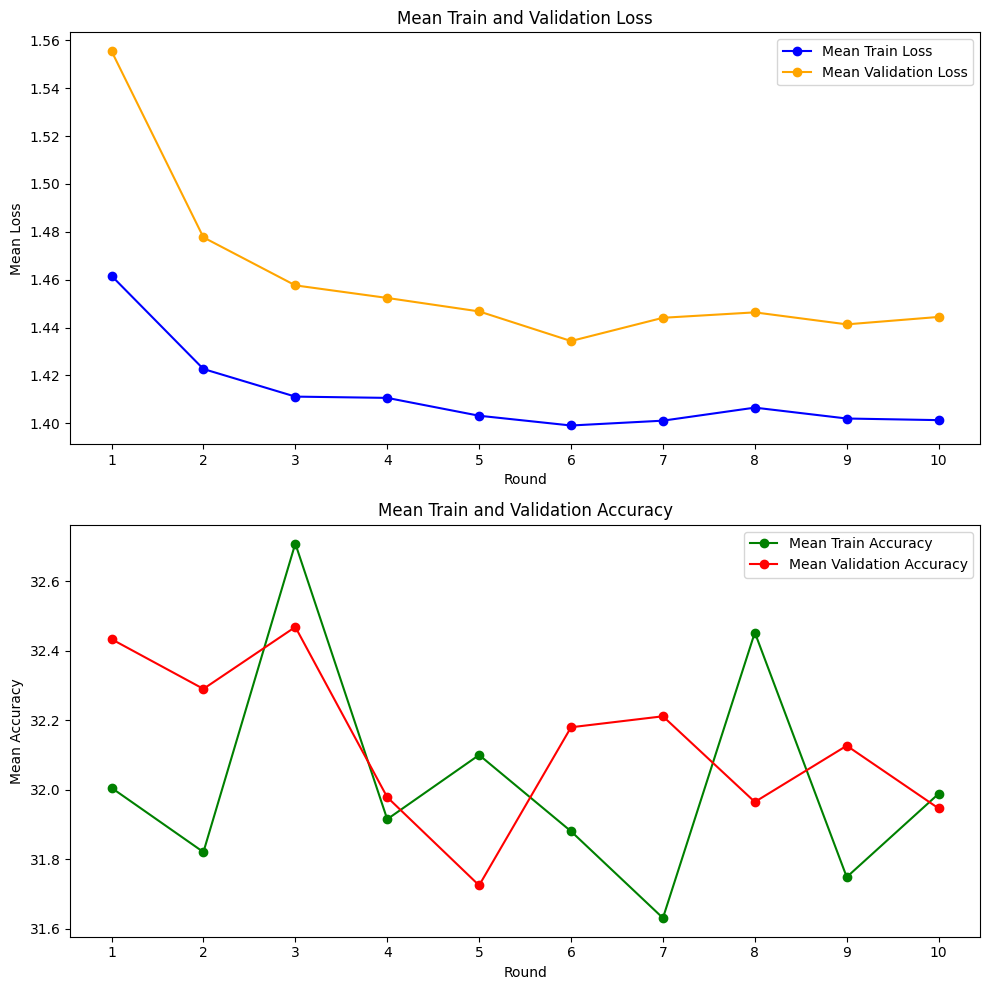

In [22]:
plot_result(fed_prox_result)

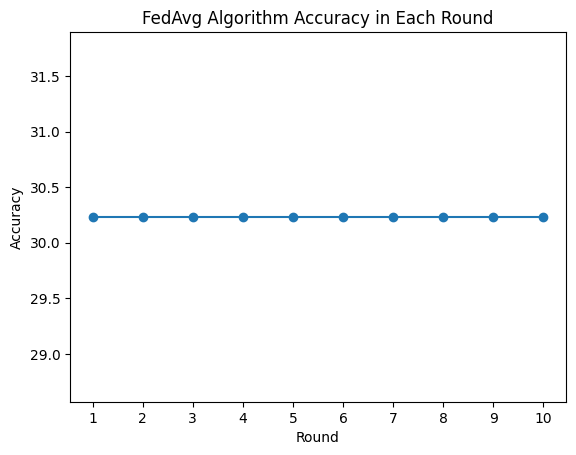

In [23]:
rounds = range(1, len(fed_prox_round_accuracy) + 1)

# Plot the accuracy values
plt.plot(rounds, fed_prox_round_accuracy, marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('FedAvg Algorithm Accuracy in Each Round')
plt.xticks(rounds)

# Display the plot
plt.show()

# Model robustness

## Sharpness Aware Minimization

In [11]:
fed_prox = FedProxAlgorithm_SAM(model=ConvGRUModel,
                            n_gru_hidden_units=n_gru_hidden_units,
                            num_class=N_MOTION,
                            timestamp=T_MAX,
                            train_loader=client_loaders,
                            mu=0.1
                            )

fed_prox_SAM_round_accuracy, fed_prox_SAM_result = fed_prox.run(num_rounds=10,
                                                                num_epochs=4
                                                                )

# Save to a file using pickle
with open('./results/fed_prox_SAM_result.pkl', 'wb') as file:
    pickle.dump(fed_prox_SAM_result, file)

with open('./results/fed_prox_SAM_round_accuracy.pkl', 'wb') as file:
    pickle.dump(fed_prox_SAM_round_accuracy, file)

---------- Round 1/10 ----------

Training on Client 1
        Epoch: 1, Train Loss: 3.5064, Train Accuracy: 25.60%,  Val Loss: 1.3847, Val Accuracy: 22.50%
        Epoch: 2, Train Loss: 5.2315, Train Accuracy: 26.34%,  Val Loss: 1.3847, Val Accuracy: 25.71%
        Epoch: 3, Train Loss: 5.4535, Train Accuracy: 26.37%,  Val Loss: 1.3833, Val Accuracy: 25.71%
        Epoch: 4, Train Loss: 5.4749, Train Accuracy: 24.47%,  Val Loss: 1.3818, Val Accuracy: 22.50%

Training on Client 2
        Epoch: 1, Train Loss: 3.2636, Train Accuracy: 31.59%,  Val Loss: 1.3658, Val Accuracy: 33.81%
        Epoch: 2, Train Loss: 5.4957, Train Accuracy: 34.78%,  Val Loss: 1.3677, Val Accuracy: 33.81%
        Epoch: 3, Train Loss: 6.0611, Train Accuracy: 34.78%,  Val Loss: 1.3641, Val Accuracy: 33.81%
        Epoch: 4, Train Loss: 6.1383, Train Accuracy: 34.78%,  Val Loss: 1.3637, Val Accuracy: 33.81%

Training on Client 3
        Epoch: 1, Train Loss: 3.0274, Train Accuracy: 33.04%,  Val Loss: 1.3548, Val 

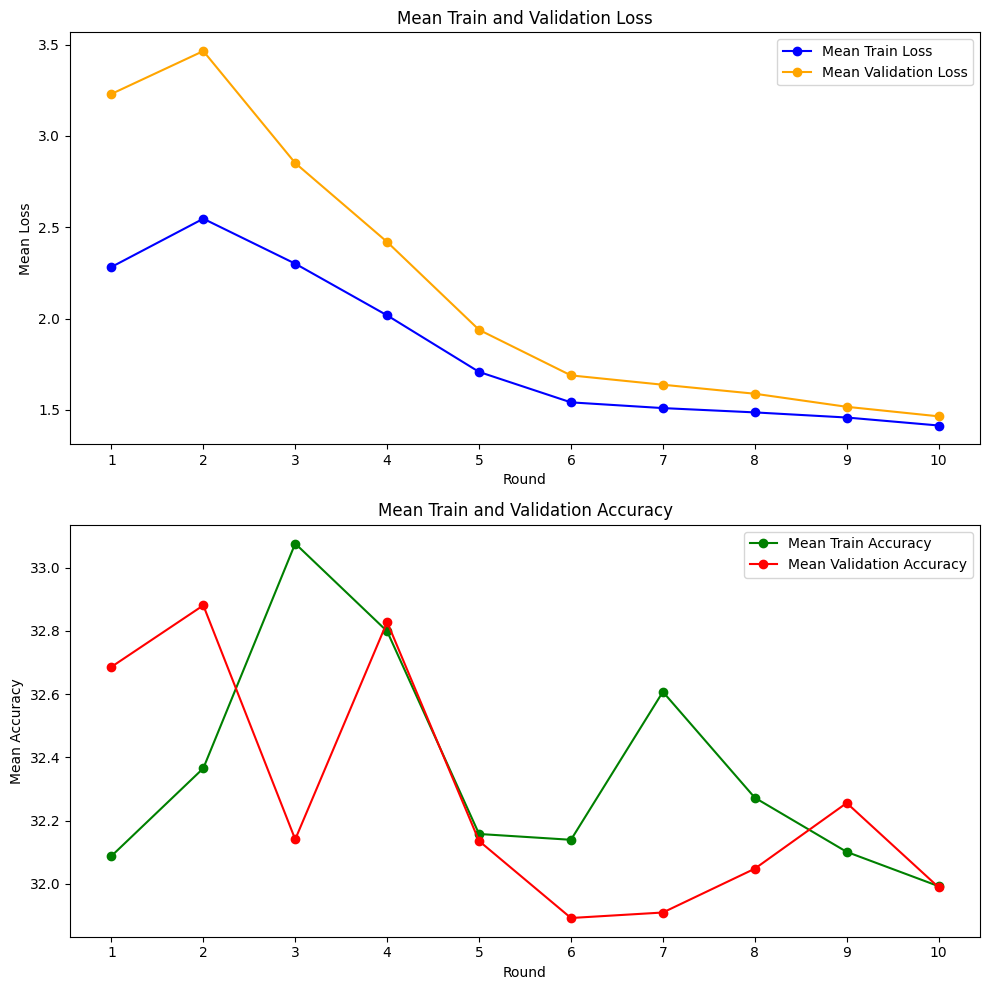

In [12]:
plot_result(fed_prox_SAM_result)

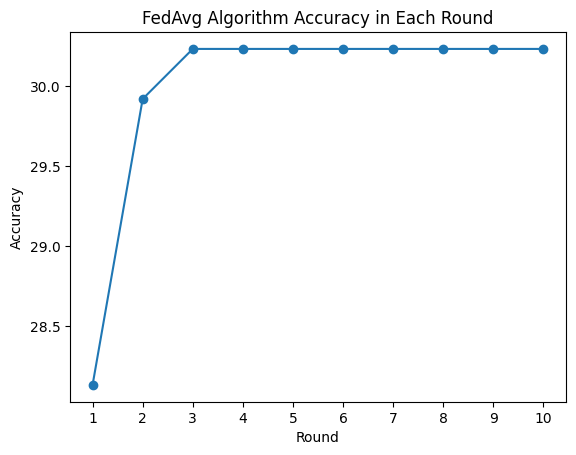

In [13]:
rounds = range(1, len(fed_prox_SAM_round_accuracy) + 1)

# Plot the accuracy values
plt.plot(rounds, fed_prox_SAM_round_accuracy, marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('FedAvg Algorithm Accuracy in Each Round')
plt.xticks(rounds)

# Display the plot
plt.show()

## FGSM

In [14]:
fed_prox = FedProxAlgorithm_FGSM(model=ConvGRUModel,
                            n_gru_hidden_units=n_gru_hidden_units,
                            num_class=N_MOTION,
                            timestamp=T_MAX,
                            train_loader=client_loaders,
                            mu=0.1
                            )

fed_prox_FGSM_round_accuracy, fed_prox_FGSM_result = fed_prox.run(num_rounds=10,
                                                                num_epochs=4
                                                                )

# Save to a file using pickle
with open('./results/fed_prox_FGSM_result.pkl', 'wb') as file:
    pickle.dump(fed_prox_FGSM_result, file)

with open('./results/fed_prox_FGSM_round_accuracy.pkl', 'wb') as file:
    pickle.dump(fed_prox_FGSM_round_accuracy, file)

---------- Round 1/10 ----------

Training on Client 1
        Epoch: 1, Train Loss: 1.6544, Train Accuracy: 25.10%,  Val Loss: 1.3842, Val Accuracy: 22.50%
        Epoch: 2, Train Loss: 1.9817, Train Accuracy: 26.00%,  Val Loss: 1.3823, Val Accuracy: 25.71%
        Epoch: 3, Train Loss: 2.1161, Train Accuracy: 25.33%,  Val Loss: 1.3820, Val Accuracy: 25.71%
        Epoch: 4, Train Loss: 2.1305, Train Accuracy: 25.63%,  Val Loss: 1.3850, Val Accuracy: 22.50%

Training on Client 2
        Epoch: 1, Train Loss: 1.6226, Train Accuracy: 34.71%,  Val Loss: 1.3648, Val Accuracy: 33.81%
        Epoch: 2, Train Loss: 1.7587, Train Accuracy: 34.78%,  Val Loss: 1.3643, Val Accuracy: 33.81%
        Epoch: 3, Train Loss: 1.7841, Train Accuracy: 34.78%,  Val Loss: 1.3651, Val Accuracy: 33.81%
        Epoch: 4, Train Loss: 1.7982, Train Accuracy: 34.78%,  Val Loss: 1.3631, Val Accuracy: 33.81%

Training on Client 3
        Epoch: 1, Train Loss: 1.6946, Train Accuracy: 34.64%,  Val Loss: 1.3521, Val 

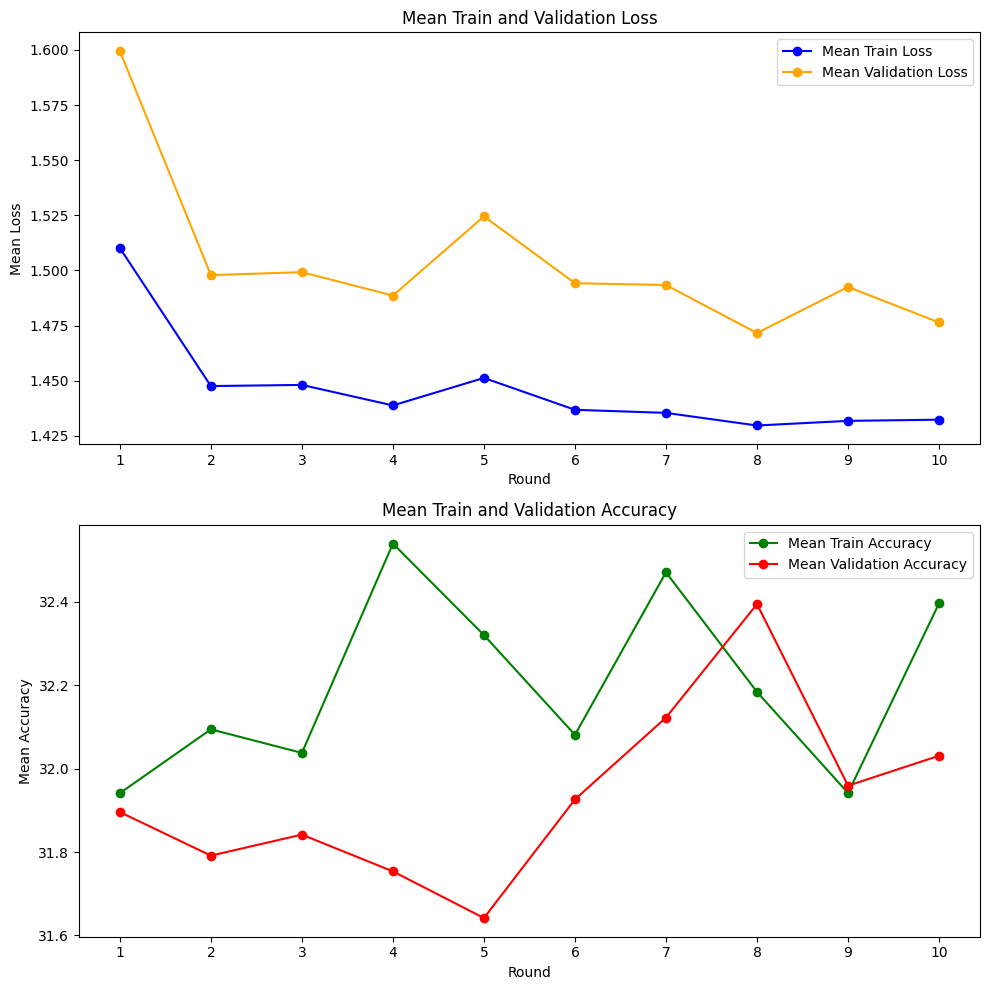

In [15]:
plot_result(fed_prox_FGSM_result)

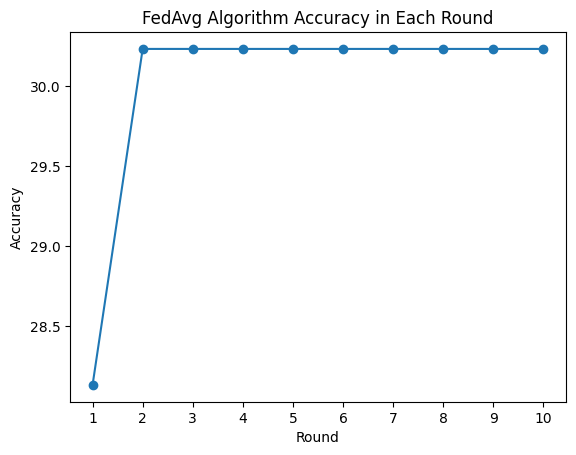

In [16]:
rounds = range(1, len(fed_prox_FGSM_round_accuracy) + 1)

# Plot the accuracy values
plt.plot(rounds, fed_prox_FGSM_round_accuracy, marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('FedAvg Algorithm Accuracy in Each Round')
plt.xticks(rounds)

# Display the plot
plt.show()